In [1]:
import numpy as np
import math
import os
import time
import matplotlib.pyplot as plt


import torch
from torchvision import datasets
from torchvision import transforms
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [2]:
print(torch.cuda.get_device_name(0))

Tesla T4


### Définition du modèle utilisé et fonctions utiles

In [3]:
# ------------------------
# Model
# ------------------------

def conv_block(c_in, c_out, k_size=4, stride=2, pad=1, use_bn=True, transpose=False):
    module = []
    if transpose:
        module.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, output_padding=pad, bias=not use_bn))
    else:
        module.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    if use_bn:
        module.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*module)


class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.conv1 = conv_block(channels, channels, k_size=3, stride=1, pad=1, use_bn=True)
        self.conv2 = conv_block(channels, channels, k_size=3, stride=1, pad=1, use_bn=True)

    def __call__(self, x):
        x = F.relu(self.conv1(x))
        return x + self.conv2(x)


class Discriminator(nn.Module):
    def __init__(self, channels=3, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = conv_block(channels, conv_dim, use_bn=False)
        self.conv2 = conv_block(conv_dim, conv_dim * 2)
        self.conv3 = conv_block(conv_dim * 2, conv_dim * 4)
        self.conv4 = conv_block(conv_dim * 4, 1, k_size=3, stride=1, pad=1, use_bn=False)

        # Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        alpha = 0.2
        x = F.leaky_relu(self.conv1(x), alpha)
        x = F.leaky_relu(self.conv2(x), alpha)
        x = F.leaky_relu(self.conv3(x), alpha)
        x = self.conv4(x)
        x = x.reshape([x.shape[0], -1]).mean(1)
        return x


class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, conv_dim=64):
        super(Generator, self).__init__()
        self.conv1 = conv_block(in_channels, conv_dim, k_size=5, stride=1, pad=2, use_bn=True)
        self.conv2 = conv_block(conv_dim, conv_dim * 2, k_size=3, stride=2, pad=1, use_bn=True)
        self.conv3 = conv_block(conv_dim * 2, conv_dim * 4, k_size=3, stride=2, pad=1, use_bn=True)
        self.res4 = ResBlock(conv_dim * 4)
        self.tconv5 = conv_block(conv_dim * 4, conv_dim * 2, k_size=3, stride=2, pad=1, use_bn=True, transpose=True)
        self.tconv6 = conv_block(conv_dim * 2, conv_dim, k_size=3, stride=2, pad=1, use_bn=True, transpose=True)
        self.conv7 = conv_block(conv_dim, out_channels, k_size=5, stride=1, pad=2, use_bn=False)

        # Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.res4(x))
        x = F.relu(self.tconv5(x))
        x = F.relu(self.tconv6(x))
        x = torch.tanh(self.conv7(x))
        return x

In [4]:
#---------------
# Data loader
#---------------

def get_dataset(ds, ds_path, transform):
    ds_full_path = os.path.join(ds_path, ds)
    if ds.lower() == 'mnist':
        return (datasets.MNIST(ds_full_path, train=True, download=True, transform=transform), datasets.MNIST(ds_full_path, train=False, download=True, transform=transform))
    elif ds.lower() == 'usps':
        return (datasets.USPS(ds_full_path, train=True, download=True, transform=transform), datasets.USPS(ds_full_path, train=False, download=True, transform=transform))
    else:
        return datasets.ImageFolder(ds_full_path, transform=transform)



def get_loaders(ds_path='./data', batch_size=128, image_size=32, a_ds='usps', b_ds='mnist'):
    mean = np.array([0.5])
    std = np.array([0.5])

    transform = transforms.Compose([transforms.Resize([image_size, image_size]),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

    (a_ds, a_test) = get_dataset(a_ds, ds_path, transform=transform)
    (b_ds, b_test) = get_dataset(b_ds, ds_path, transform=transform)

    a_ds_loader = torch.utils.data.DataLoader(dataset=a_ds,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              drop_last=True)

    a_test_loader = torch.utils.data.DataLoader(dataset=a_test,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              drop_last=True)   

    b_ds_loader = torch.utils.data.DataLoader(dataset=b_ds,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              drop_last=True)
    
    b_test_loader = torch.utils.data.DataLoader(dataset=b_test,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              drop_last=True)

    return (a_ds_loader, b_ds_loader, a_test_loader, b_test_loader)


def generate_imgs(a, b, ab_gen, ba_gen, samples_path, epoch=0, iter=0, size_dataset=0):
    ab_gen.eval()
    ba_gen.eval()

    b_fake = ab_gen(a)
    a_fake = ba_gen(b)

    a_imgs = torch.zeros((a.shape[0] * 2, 3, a.shape[2], a.shape[3]))
    b_imgs = torch.zeros((b.shape[0] * 2, 3, b.shape[2], b.shape[3]))

    even_idx = torch.arange(start=0, end=a.shape[0] * 2, step=2)
    odd_idx = torch.arange(start=1, end=a.shape[0] * 2, step=2)

    a_imgs[even_idx] = a.cpu()
    a_imgs[odd_idx] = b_fake.cpu()

    b_imgs[even_idx] = b.cpu()
    b_imgs[odd_idx] = a_fake.cpu()

    rows = math.ceil((a.shape[0] * 2) ** 0.5)
    a_imgs_ = vutils.make_grid(a_imgs, normalize=True, nrow=rows)
    b_imgs_ = vutils.make_grid(b_imgs, normalize=True, nrow=rows)

    vutils.save_image(a_imgs_, os.path.join(samples_path, 'a2b_' + str(epoch) + '.png'))
    vutils.save_image(b_imgs_, os.path.join(samples_path, 'b2a_' + str(epoch) + '.png'))

    a_imgs_ = vutils.make_grid(a_imgs, normalize=True, nrow=rows).permute(1, 2, 0)
    b_imgs_ = vutils.make_grid(b_imgs, normalize=True, nrow=rows).permute(1, 2, 0)

    plt.imshow(b_imgs_)
    plt.title("Epoch " + str(epoch) + " and iter " + str(iter) + "/" + str(size_dataset))
    plt.show()

    ab_gen.train()
    ba_gen.train()

### Main

In [5]:
EPOCHS = 3
BATCH_SIZE = 32
LOAD_MODEL = False

IMAGE_SIZE = 32
A_DS = 'usps'
A_Channels = 1
B_DS = 'mnist'
B_Channels = 1

# Directories for storing model and output samples
model_path = './model'
if not os.path.exists(model_path):
    os.makedirs(model_path)
samples_path = './samples'
if not os.path.exists(samples_path):
    os.makedirs(samples_path)
db_path = './data'
if not os.path.exists(samples_path):
    os.makedirs(samples_path)

# Networks
ab_gen = Generator(in_channels=A_Channels, out_channels=B_Channels)
ba_gen = Generator(in_channels=B_Channels, out_channels=A_Channels)
a_disc = Discriminator(channels=A_Channels)
b_disc = Discriminator(channels=B_Channels)

In [6]:
# Load previous model   
if LOAD_MODEL:
    ab_gen.load_state_dict(torch.load(os.path.join(model_path, 'ab_gen.pkl')))
    ba_gen.load_state_dict(torch.load(os.path.join(model_path, 'ba_gen.pkl')))
    a_disc.load_state_dict(torch.load(os.path.join(model_path, 'a_disc.pkl')))
    b_disc.load_state_dict(torch.load(os.path.join(model_path, 'b_disc.pkl')))

In [7]:
# Define Optimizers
g_opt = optim.Adam(list(ab_gen.parameters()) + list(ba_gen.parameters()), lr=0.0002, betas=(0.5, 0.999),
                   weight_decay=2e-5)
d_opt = optim.Adam(list(a_disc.parameters()) + list(b_disc.parameters()), lr=0.0002, betas=(0.5, 0.999),
                   weight_decay=2e-5)

In [8]:
# Data loaders
a_loader, b_loader, a_loader_test, b_loader_test = get_loaders(db_path, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, a_ds=A_DS, b_ds=B_DS)
iters_per_epoch = min(len(a_loader), len(b_loader))

# Fix images for viz
a_fixed = iter(a_loader).next()[0]
b_fixed = iter(b_loader).next()[0]

# Fix images for viz
a_fixed_test = iter(a_loader_test).next()[0]
b_fixed_test = iter(b_loader_test).next()[0]


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
# GPU Compatibility
is_cuda = torch.cuda.is_available()
if is_cuda:
    ab_gen, ba_gen = ab_gen.cuda(), ba_gen.cuda()
    a_disc, b_disc = a_disc.cuda(), b_disc.cuda()

    a_fixed = a_fixed.cuda()
    b_fixed = b_fixed.cuda()

    a_fixed_test = a_fixed_test.cuda()
    b_fixed_test = b_fixed_test.cuda()

Train Dataset


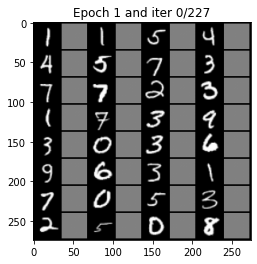

Test Dataset


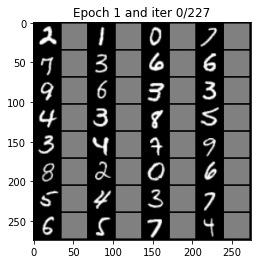

a_d_loss:0.8525	 a_g_loss:0.4053	 a_g_ctnt_loss:0.7835	 b_d_loss:0.5587	 b_g_loss:0.1865	 b_g_ctnt_loss:0.826
Train Dataset


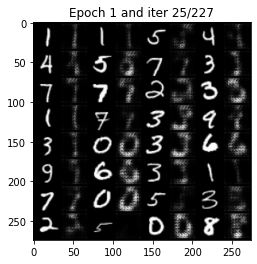

Test Dataset


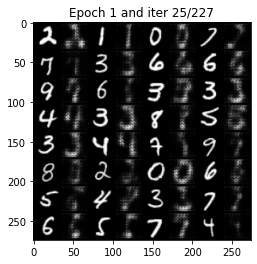

a_d_loss:0.229	 a_g_loss:0.4242	 a_g_ctnt_loss:0.2299	 b_d_loss:0.219	 b_g_loss:0.3575	 b_g_ctnt_loss:0.1817
Train Dataset


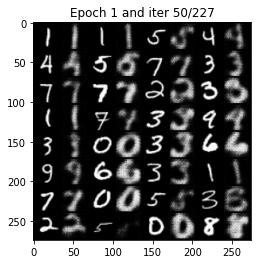

Test Dataset


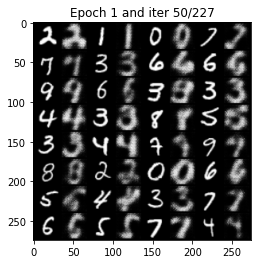

a_d_loss:0.227	 a_g_loss:0.3191	 a_g_ctnt_loss:0.1387	 b_d_loss:0.2569	 b_g_loss:0.34	 b_g_ctnt_loss:0.1196
Train Dataset


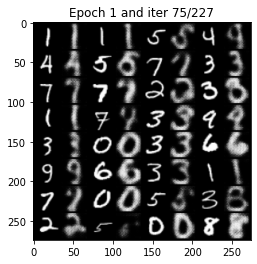

Test Dataset


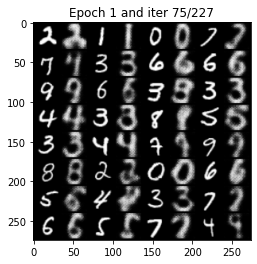

a_d_loss:0.2161	 a_g_loss:0.3703	 a_g_ctnt_loss:0.1352	 b_d_loss:0.2358	 b_g_loss:0.3873	 b_g_ctnt_loss:0.1034
Train Dataset


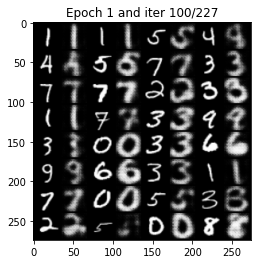

Test Dataset


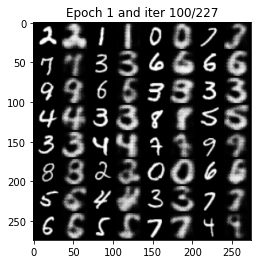

a_d_loss:0.2568	 a_g_loss:0.6088	 a_g_ctnt_loss:0.1218	 b_d_loss:0.2409	 b_g_loss:0.2954	 b_g_ctnt_loss:0.098
Train Dataset


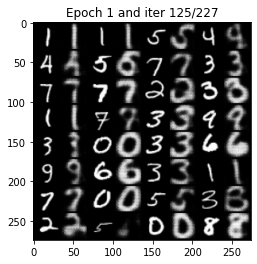

Test Dataset


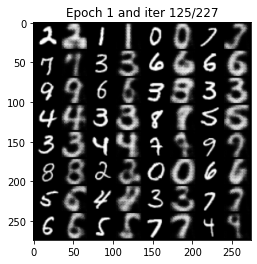

a_d_loss:0.2336	 a_g_loss:0.3976	 a_g_ctnt_loss:0.134	 b_d_loss:0.2345	 b_g_loss:0.2675	 b_g_ctnt_loss:0.1114
Train Dataset


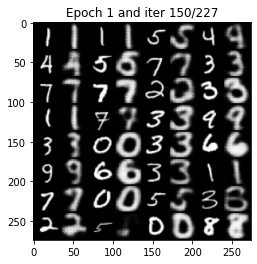

Test Dataset


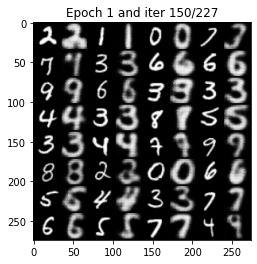

a_d_loss:0.2226	 a_g_loss:0.3768	 a_g_ctnt_loss:0.1266	 b_d_loss:0.2304	 b_g_loss:0.3205	 b_g_ctnt_loss:0.1024
Train Dataset


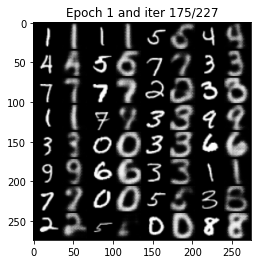

Test Dataset


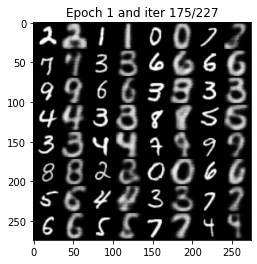

a_d_loss:0.2294	 a_g_loss:0.3359	 a_g_ctnt_loss:0.1295	 b_d_loss:0.2365	 b_g_loss:0.3768	 b_g_ctnt_loss:0.0904
Train Dataset


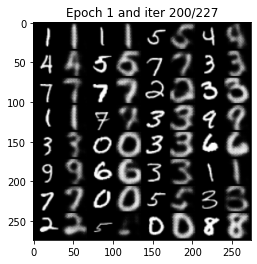

Test Dataset


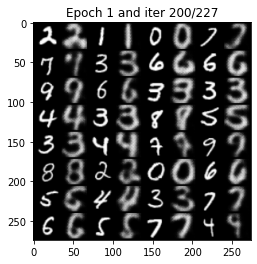

a_d_loss:0.2277	 a_g_loss:0.3939	 a_g_ctnt_loss:0.1383	 b_d_loss:0.2395	 b_g_loss:0.3283	 b_g_ctnt_loss:0.0906
Train Dataset


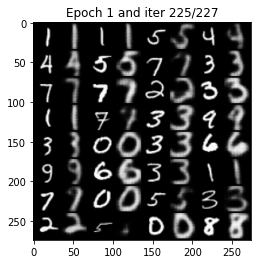

Test Dataset


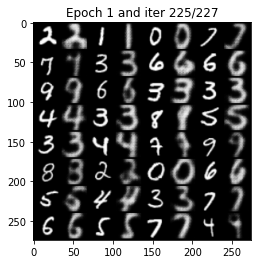

a_d_loss:0.228	 a_g_loss:0.2357	 a_g_ctnt_loss:0.1206	 b_d_loss:0.2498	 b_g_loss:0.3495	 b_g_ctnt_loss:0.0884
Epoch: 1/3  21.0 seconds 
Train Dataset


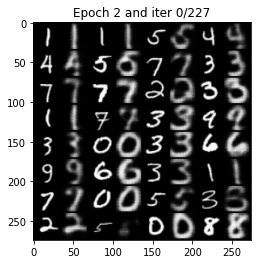

Test Dataset


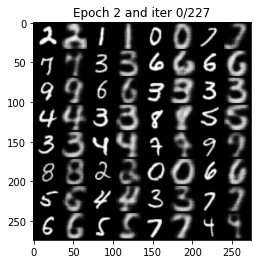

a_d_loss:0.2878	 a_g_loss:0.1331	 a_g_ctnt_loss:0.1247	 b_d_loss:0.2491	 b_g_loss:0.2635	 b_g_ctnt_loss:0.0959
Train Dataset


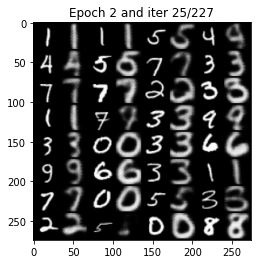

Test Dataset


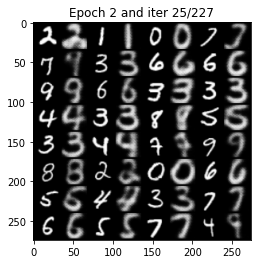

a_d_loss:0.2093	 a_g_loss:0.334	 a_g_ctnt_loss:0.1226	 b_d_loss:0.223	 b_g_loss:0.3704	 b_g_ctnt_loss:0.1014
Train Dataset


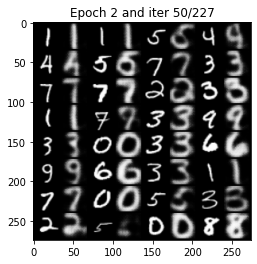

Test Dataset


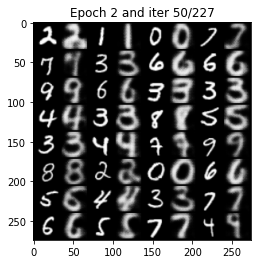

a_d_loss:0.2604	 a_g_loss:0.6372	 a_g_ctnt_loss:0.1053	 b_d_loss:0.2467	 b_g_loss:0.2659	 b_g_ctnt_loss:0.0986
Train Dataset


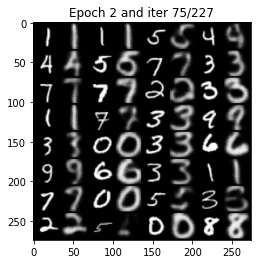

Test Dataset


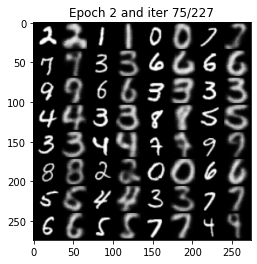

a_d_loss:0.2299	 a_g_loss:0.3147	 a_g_ctnt_loss:0.1092	 b_d_loss:0.2358	 b_g_loss:0.31	 b_g_ctnt_loss:0.0859
Train Dataset


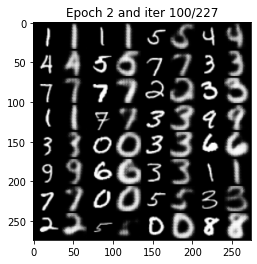

Test Dataset


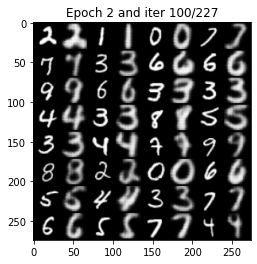

a_d_loss:0.2403	 a_g_loss:0.2267	 a_g_ctnt_loss:0.109	 b_d_loss:0.2261	 b_g_loss:0.3721	 b_g_ctnt_loss:0.0884
Train Dataset


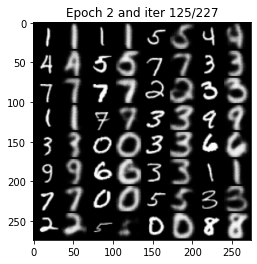

Test Dataset


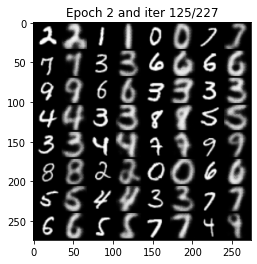

a_d_loss:0.2267	 a_g_loss:0.3523	 a_g_ctnt_loss:0.0973	 b_d_loss:0.2293	 b_g_loss:0.2764	 b_g_ctnt_loss:0.0895
Train Dataset


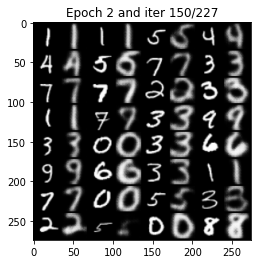

Test Dataset


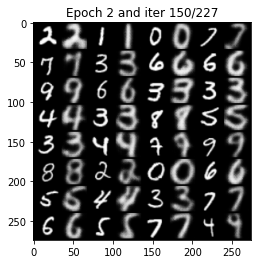

a_d_loss:0.2257	 a_g_loss:0.3285	 a_g_ctnt_loss:0.0964	 b_d_loss:0.234	 b_g_loss:0.3337	 b_g_ctnt_loss:0.0924
Train Dataset


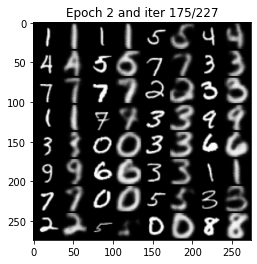

Test Dataset


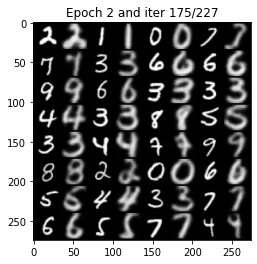

a_d_loss:0.221	 a_g_loss:0.2943	 a_g_ctnt_loss:0.1085	 b_d_loss:0.2454	 b_g_loss:0.2971	 b_g_ctnt_loss:0.0949
Train Dataset


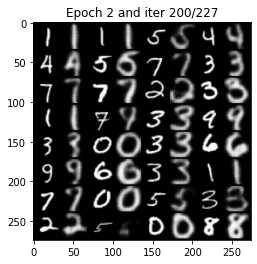

Test Dataset


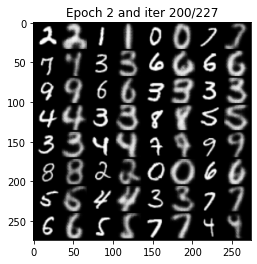

a_d_loss:0.2371	 a_g_loss:0.2846	 a_g_ctnt_loss:0.1197	 b_d_loss:0.2597	 b_g_loss:0.2837	 b_g_ctnt_loss:0.0851
Train Dataset


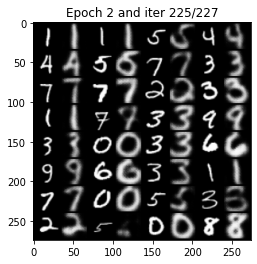

Test Dataset


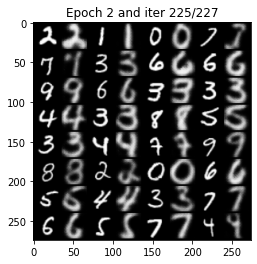

a_d_loss:0.2133	 a_g_loss:0.3665	 a_g_ctnt_loss:0.0968	 b_d_loss:0.2485	 b_g_loss:0.2764	 b_g_ctnt_loss:0.0876
Epoch: 2/3  42.0 seconds 
Train Dataset


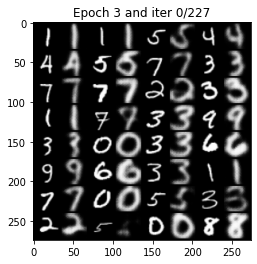

Test Dataset


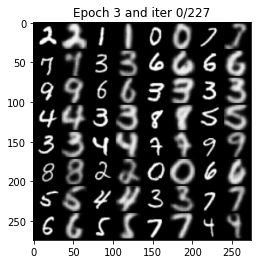

a_d_loss:0.251	 a_g_loss:0.3875	 a_g_ctnt_loss:0.1004	 b_d_loss:0.2381	 b_g_loss:0.2457	 b_g_ctnt_loss:0.0869
Train Dataset


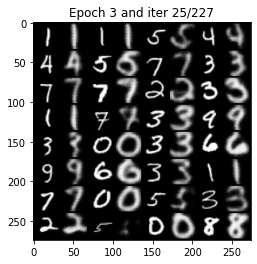

Test Dataset


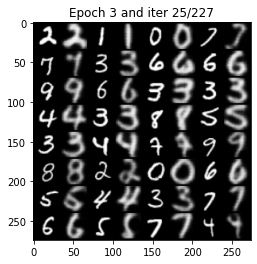

a_d_loss:0.232	 a_g_loss:0.386	 a_g_ctnt_loss:0.107	 b_d_loss:0.2465	 b_g_loss:0.3381	 b_g_ctnt_loss:0.091
Train Dataset


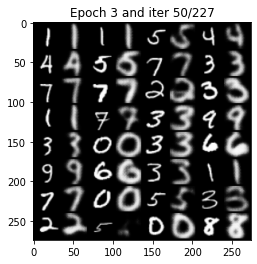

Test Dataset


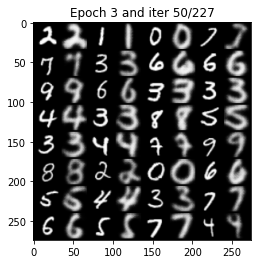

a_d_loss:0.2271	 a_g_loss:0.3688	 a_g_ctnt_loss:0.0973	 b_d_loss:0.2493	 b_g_loss:0.2602	 b_g_ctnt_loss:0.0918
Train Dataset


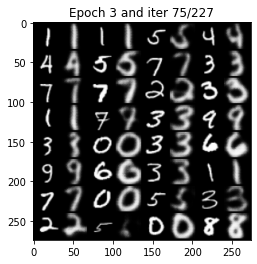

Test Dataset


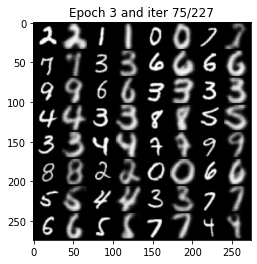

a_d_loss:0.2577	 a_g_loss:0.2007	 a_g_ctnt_loss:0.0981	 b_d_loss:0.2313	 b_g_loss:0.3389	 b_g_ctnt_loss:0.0983
Train Dataset


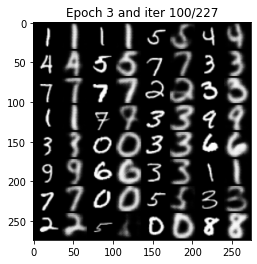

Test Dataset


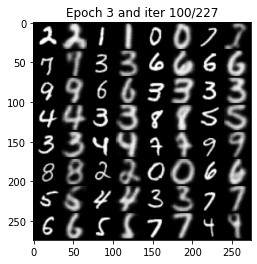

a_d_loss:0.2282	 a_g_loss:0.3692	 a_g_ctnt_loss:0.0912	 b_d_loss:0.2376	 b_g_loss:0.3878	 b_g_ctnt_loss:0.0898
Train Dataset


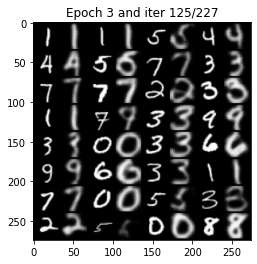

Test Dataset


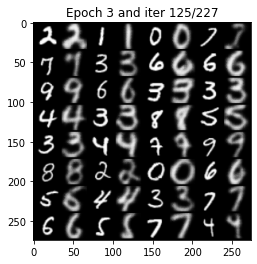

a_d_loss:0.2294	 a_g_loss:0.4129	 a_g_ctnt_loss:0.0917	 b_d_loss:0.2545	 b_g_loss:0.1916	 b_g_ctnt_loss:0.0845
Train Dataset


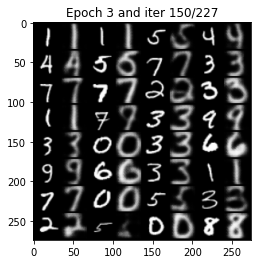

Test Dataset


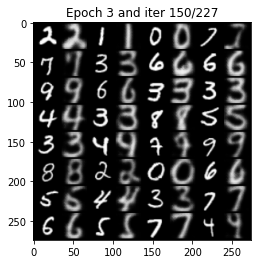

a_d_loss:0.2076	 a_g_loss:0.3555	 a_g_ctnt_loss:0.0796	 b_d_loss:0.2223	 b_g_loss:0.3581	 b_g_ctnt_loss:0.0881
Train Dataset


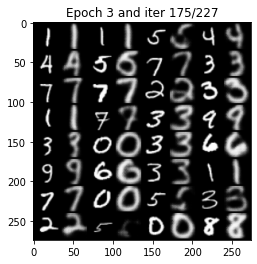

Test Dataset


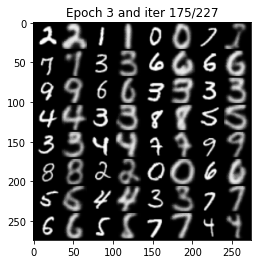

a_d_loss:0.241	 a_g_loss:0.3311	 a_g_ctnt_loss:0.1091	 b_d_loss:0.218	 b_g_loss:0.3248	 b_g_ctnt_loss:0.0899
Train Dataset


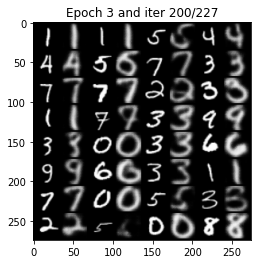

Test Dataset


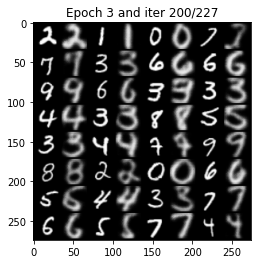

a_d_loss:0.2385	 a_g_loss:0.2995	 a_g_ctnt_loss:0.0962	 b_d_loss:0.2539	 b_g_loss:0.3638	 b_g_ctnt_loss:0.0943
Train Dataset


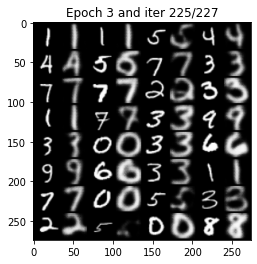

Test Dataset


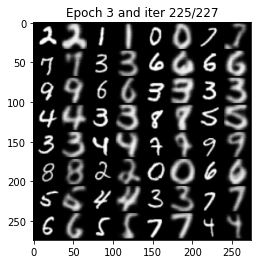

a_d_loss:0.2333	 a_g_loss:0.4274	 a_g_ctnt_loss:0.098	 b_d_loss:0.2316	 b_g_loss:0.3672	 b_g_ctnt_loss:0.0877
Epoch: 3/3  64.0 seconds 


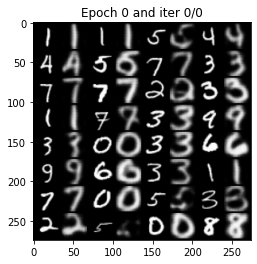

In [11]:
t0 = time.time()

# Cycle-GAN Training
for epoch in range(EPOCHS):
    ab_gen.train()
    ba_gen.train()
    a_disc.train()
    b_disc.train()

    for i, (a_data, b_data) in enumerate(zip(a_loader, b_loader)):

        # Loading data
        a_real, _ = a_data
        b_real, _ = b_data

        if is_cuda:
            a_real, b_real = a_real.cuda(), b_real.cuda()

        # Fake Images
        b_fake = ab_gen(a_real)
        a_fake = ba_gen(b_real)
        

        # Training discriminator
        a_real_out = a_disc(a_real)
        a_fake_out = a_disc(a_fake.detach())
        a_d_loss = (torch.mean((a_real_out - 1) ** 2) + torch.mean(a_fake_out ** 2)) / 2

        b_real_out = b_disc(b_real)
        b_fake_out = b_disc(b_fake.detach())
        b_d_loss = (torch.mean((b_real_out - 1) ** 2) + torch.mean(b_fake_out ** 2)) / 2

        d_opt.zero_grad()
        d_loss = a_d_loss + b_d_loss
        d_loss.backward()
        d_opt.step()

        # Training Generator
        a_fake_out = a_disc(a_fake)
        b_fake_out = b_disc(b_fake)

        a_g_loss = torch.mean((a_fake_out - 1) ** 2)
        b_g_loss = torch.mean((b_fake_out - 1) ** 2)
        g_gan_loss = a_g_loss + b_g_loss

        a_g_ctnt_loss = (a_real - ba_gen(b_fake)).abs().mean()
        b_g_ctnt_loss = (b_real - ab_gen(a_fake)).abs().mean()
        g_ctnt_loss = a_g_ctnt_loss + b_g_ctnt_loss

        g_opt.zero_grad()
        g_loss = g_gan_loss + g_ctnt_loss
        g_loss.backward()
        g_opt.step()

        if i % 25 == 0:
            print("Train Dataset")
            generate_imgs(a_fixed, b_fixed, ab_gen, ba_gen, samples_path, epoch=epoch + 1, iter=i, size_dataset=len(a_loader))
            print("Test Dataset")
            generate_imgs(a_fixed_test, b_fixed_test, ab_gen, ba_gen, samples_path, epoch=epoch + 1, iter=i, size_dataset=len(a_loader))
            print("a_d_loss:" + str(round(a_d_loss.item(), 4))
            + "\t a_g_loss:" + str(round(a_g_loss.item(), 4))
            + "\t a_g_ctnt_loss:" + str(round(a_g_ctnt_loss.item(), 4))
            + "\t b_d_loss:" + str(round(b_d_loss.item(), 4))
            + "\t b_g_loss:" + str(round(b_g_loss.item(), 4))
            + "\t b_g_ctnt_loss:" + str(round(b_g_ctnt_loss.item(), 4)))

    torch.save(ab_gen.state_dict(), os.path.join(model_path, 'ab_gen.pkl'))
    torch.save(ba_gen.state_dict(), os.path.join(model_path, 'ba_gen.pkl'))
    torch.save(a_disc.state_dict(), os.path.join(model_path, 'a_disc.pkl'))
    torch.save(b_disc.state_dict(), os.path.join(model_path, 'b_disc.pkl'))

    print('========================================================')
    print("Epoch: " + str(epoch + 1) + "/" + str(EPOCHS) + "  " + str(round(time.time() - t0, 0)) + " seconds ")
    print('========================================================')

generate_imgs(a_fixed, b_fixed, ab_gen, ba_gen, samples_path)


# Lecture des images

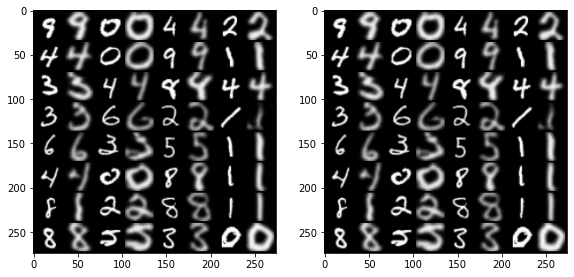

In [9]:
#Import library
from IPython.display import Image
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.image as img
  
fichiers = [f for f in listdir('./samples') if isfile(join('./samples', f))]
# Load image from local storage
# Affiche la première image et une fois toutes les 10 images
# Image(filename = './samples/' + 'b2a_1.png', width = 600, height = 300)
i=0
images = []

for imB2A in fichiers:
  if (imB2A[0:3] == 'b2a'):
    if (int(imB2A[4:].replace('.png',''))%10 == 0):
      #Image(filename = './samples/' + imB2A, width = 600, height = 300)
      # reading png image file
      images.append(img.imread('./samples/' + imB2A))

plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(images):
    plt.subplot(len(images) /columns + 1, columns, i + 1)
    plt.imshow(image)